In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from hmmlearn.hmm import GaussianHMM
from sklearn.metrics import confusion_matrix
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns 
from itertools import permutations
import warnings
warnings.filterwarnings("ignore")

In [2]:
b_health_class = pd.read_csv('B.HEALTH classification.csv')
b_health_comp = pd.read_csv('B.Health components.csv')
sleep_qual_class = pd.read_csv('SleepQual classification.csv')
sleep_qual_comp = pd.read_csv('SleepQual components.csv')

b_health_class['subject'] = b_health_class['subject'].ffill()
b_health_comp['subject'] = b_health_comp['subject'].ffill()
sleep_qual_class['subject'] = sleep_qual_class['subject'].ffill()
sleep_qual_comp['subject'] = sleep_qual_comp['subject'].ffill()

merged = b_health_class.merge(b_health_comp, on=['subject', 'day'], how='inner', suffixes=('', '_bhc'))
merged = merged.merge(sleep_qual_class, on=['subject', 'day'], how='inner', suffixes=('', '_sqc'))
merged = merged.merge(sleep_qual_comp, on=['subject', 'day'], how='inner', suffixes=('', '_sqcomp'))

print(f"Merged data shape: {merged.shape}")

Merged data shape: (182, 51)


In [3]:
merged

,subject,day,step count,distance travelled (km),calories burnt (kcal),acive time (minutes),actual sleep duration (minutes),sleep onset latency (minutes),duration in bed (minutes),efficiency (%),...,deep sleep percentage (%)_sqc,REM percentage(%),label_sqc,comp 1,comp 2,comp 3,comp 4,comp 5,comp 6,SleepQual
0,1.0,1,3016,2.28,2151,32,455,29.0,518,88.000000,...,12.548263,24.000000,0,1,0,0,3,0,0,4
1,1.0,2,1790,1.39,2129,19,320,10.0,360,89.000000,...,33.300000,13.800000,0,0,2,0,0,0,1,2
2,1.0,3,2864,2.07,2032,29,453,23.0,504,90.000000,...,11.111111,26.000000,0,1,0,0,3,0,1,4
3,1.0,4,1419,1.80,1713,15,449,32.5,518,87.000000,...,10.424710,27.000000,1,2,0,0,3,0,1,5
4,1.0,5,1698,1.30,1725,18,358,21.0,403,89.000000,...,13.895782,23.000000,1,1,2,0,3,0,0,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
177,24.0,3,6752,4.59,222,67,570,2.5,575,99.130435,...,17.391304,20.434783,0,0,0,0,0,0,0,0
178,24.0,4,6207,3.89,201,61,535,5.5,546,97.985348,...,10.073260,21.978022,0,0,0,0,0,0,0,0
179,24.0,5,6202,4.21,204,67,480,0.0,480,100.000000,...,4.166667,23.958333,0,0,0,0,0,1,0,1
180,24.0,6,1011,0.23,19,21,300,32.5,365,82.191781,...,8.767123,18.356164,2,2,3,1,3,1,1,11


In [4]:
merged.columns

Index(['subject', 'day', 'step count', 'distance travelled (km)',
       'calories burnt (kcal)', 'acive time (minutes)',
       'actual sleep duration (minutes)', 'sleep onset latency (minutes)',
       'duration in bed (minutes)', 'efficiency (%)', 'in bed time',
       'out bed time', 'in bed awake duration (minutes)',
       'light sleep duration (minutes)',
       'deep sleep duration (minutes) (minutes)', 'REM duration (minutes)',
       'awake percentage (%)', 'light sleep percentage (%)',
       'deep sleep percentage (%)', 'REM percentage (%)',
       'total phone usage / day (minutes)',
       'night time phone usage / day (minutes)', 'phone unlock count / day',
       'label', 'SleepQual index', 'steps index', 'PA index', 'ST index',
       'B.Heath', 'duration in bed (minutes)_sqc', 'in bed time_sqc',
       'out bed time_sqc', 'actual sleep duration (minutes)_sqc',
       'sleep onset latency (minutes)_sqc',
       'in bed awake duration (minutes)_sqc', 'efficiency (%)_sqc

#### Observed Features
- `total phone usage / day (minutes)`: total phone usage in minutes
- `night time phone usage / day (minutes)`: phone usage in minutes during the night
- `awake percentage (%)`: percentage of time in bed spent awake
- `sleep onset latency (minutes)`: time it takes to fall asleep in minutes
- `actual sleep duration (minutes)`: actual sleep duration in minutes


In [5]:
feature_cols = [
    'total phone usage / day (minutes)',
    'night time phone usage / day (minutes)',
    'awake percentage (%)',
    'sleep onset latency (minutes)',
    'actual sleep duration (minutes)'
]

sleep = merged[feature_cols + ['SleepQual']].copy()

# the lower the score, the better the sleep quality
def sleep_level(x):
    if x <= 3: return 0
    elif x <= 6: return 1
    else: return 2

sleep['Sleep_Quality_State'] = sleep['SleepQual'].apply(sleep_level)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(sleep[feature_cols])

states = sleep['Sleep_Quality_State'].values
n_states = len(np.unique(states))

print(f"Number of states: {n_states}")
print(f"State distribution: {np.bincount(states)}")
print(f"X_scaled shape: {X_scaled.shape}")

Number of states: 3
State distribution: [95 58 29]
X_scaled shape: (182, 5)


In [6]:
# Initialize HMM
model = GaussianHMM(n_components=n_states, covariance_type="full", n_iter=200, init_params="", random_state=63)

# Uniform start prob
model.startprob_ = np.ones(n_states) / n_states
print(f"Start prob: {model.startprob_}")

# Transition matrix
A = np.random.rand(n_states, n_states)
A = A / A.sum(axis=1, keepdims=True)
model.transmat_ = A
print(f"Transition matrix:\n{model.transmat_}")

# Emission matrix
means = []
covs = []

for s in np.unique(states):
    X_s = X_scaled[states == s]
    means.append(X_s.mean(axis=0))
    covs.append(np.cov(X_s.T) + 1e-3 * np.eye(X_s.shape[1]))

model.means_ = np.array(means)
model.covars_ = np.array(covs)

print(f"Means shape: {model.means_.shape}")

Start prob: [0.33333333 0.33333333 0.33333333]
Transition matrix:
[[0.43584728 0.04900896 0.51514377]
 [0.3973599  0.07786504 0.52477506]
 [0.48187348 0.27655104 0.24157548]]
Means shape: (3, 5)


In [7]:
model.fit(X_scaled)

,n_components,3
,covariance_type,'full'
,min_covar,0.001
,startprob_prior,1.0
,transmat_prior,1.0
,means_prior,0
,means_weight,0
,covars_prior,0.01
,covars_weight,1
,algorithm,'viterbi'
,random_state,63


In [8]:
model.means_, model.covars_

(array([[-0.81964916, -0.73627378, -0.72315992, -0.66231323,  0.37859165],
        [ 0.82600444,  0.49856826,  0.17655052,  0.31455224,  0.02598863],
        [ 0.70726977,  0.9801682 ,  1.40632913,  1.07145014, -0.90400742]]),
 array([[[ 7.19938440e-02,  8.63850958e-02,  5.10022388e-02,
           5.28477923e-02, -4.68484533e-04],
         [ 8.63850958e-02,  1.20297595e-01,  4.66146233e-02,
           5.05399385e-02, -3.37800257e-03],
         [ 5.10022388e-02,  4.66146233e-02,  1.60859893e-01,
           1.53935356e-01, -9.95023507e-02],
         [ 5.28477923e-02,  5.05399385e-02,  1.53935356e-01,
           1.85418332e-01,  6.48284895e-02],
         [-4.68484533e-04, -3.37800257e-03, -9.95023507e-02,
           6.48284895e-02,  9.64789561e-01]],
 
        [[ 6.48549214e-01, -1.10485060e-01,  1.55950203e-01,
           2.04130089e-01,  5.09803112e-02],
         [-1.10485060e-01,  7.40512909e-01,  1.30967594e-01,
           7.35215459e-02, -2.46778062e-01],
         [ 1.55950203e-01,  

In [9]:
def standard_graph(variable_num, variable_name):
    means = model.means_[:, variable_num]
    covariances = model.covars_[:, variable_num, variable_num]
    x = np.linspace(means.min() - 3 * covariances.max(), means.max() + 3 * covariances.max(), 1000)
    
    for i in range(3):
        y = norm.pdf(x, means[i], covariances[i])
        axes[variable_num].plot(x, y, c=colors[i], label=labels[i])
    
    axes[variable_num].set_xlabel(f'{column.title()}, standardized')
    axes[variable_num].set_ylabel('Density')
    axes[variable_num].set_title(f'Distribution of {column.title()}, standardized')
    axes[variable_num].legend(title='Quality of Sleep')

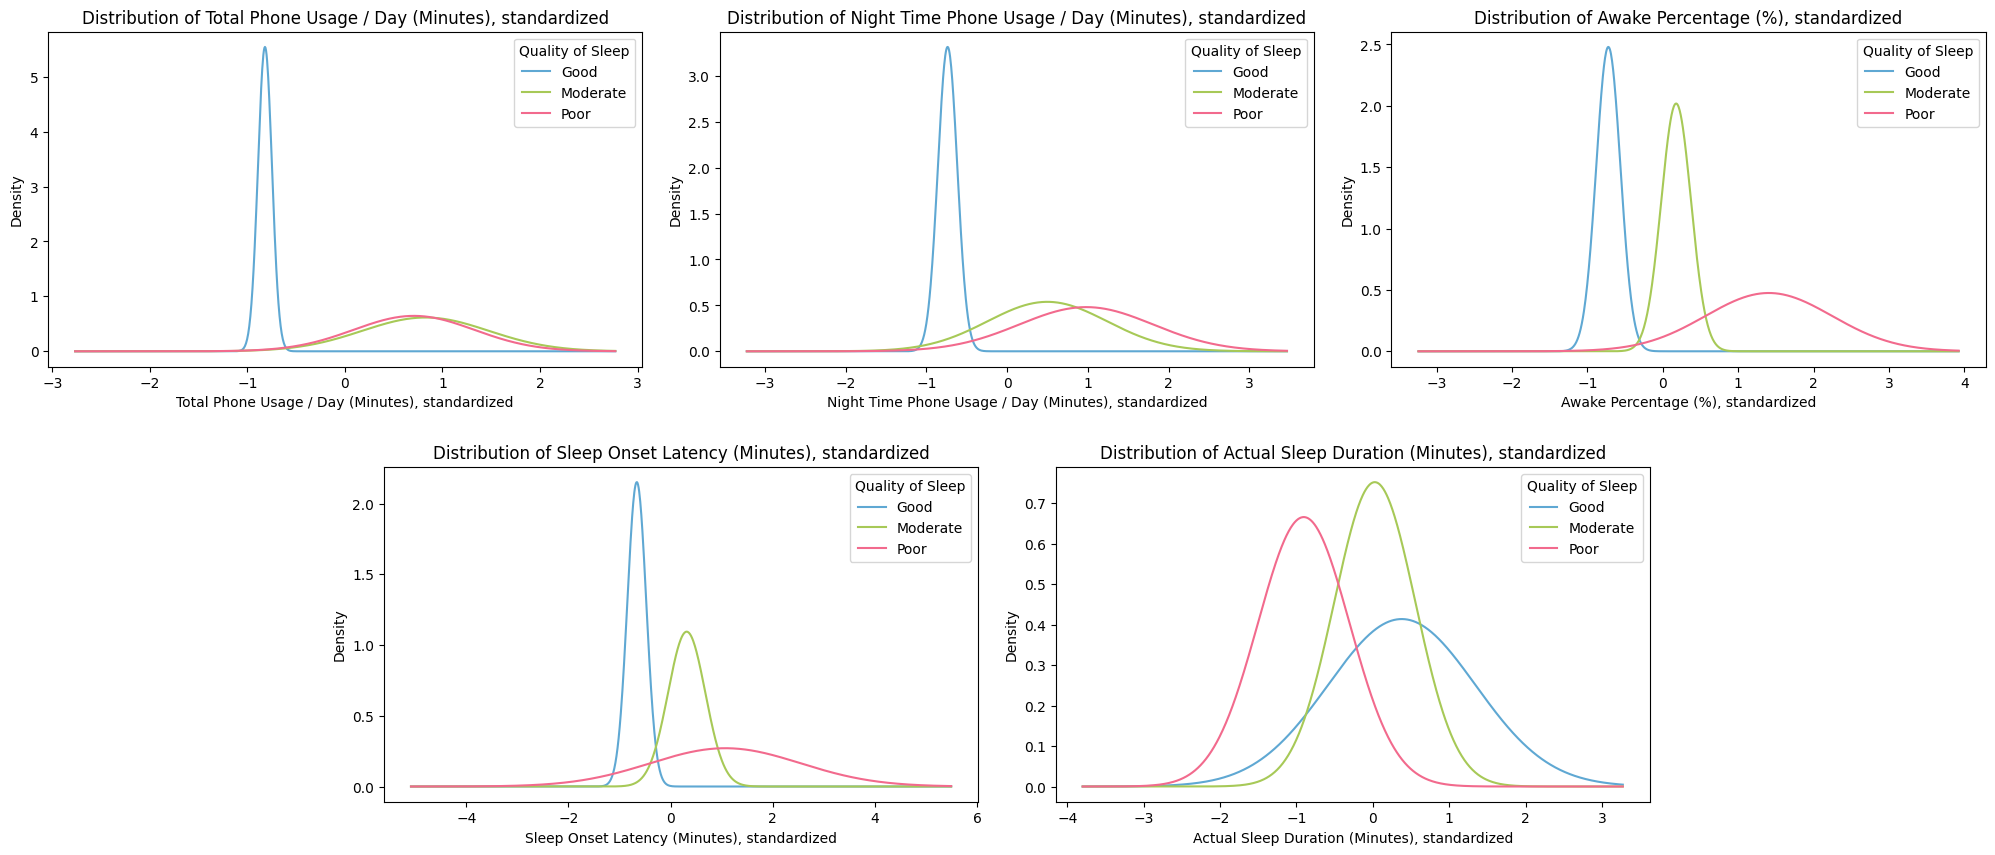

In [22]:
fig = plt.figure(figsize=(25, 10))
gs = fig.add_gridspec(2, 6, hspace=0.3, wspace=0.3)

# Top row: 3 plots
axes = [
    fig.add_subplot(gs[0, 0:2]),  # First plot spans columns 0-1
    fig.add_subplot(gs[0, 2:4]),  # Second plot spans columns 2-3
    fig.add_subplot(gs[0, 4:6]),  # Third plot spans columns 4-5
    # Bottom row: 2 plots (centered)
    fig.add_subplot(gs[1, 1:3]),  # Fourth plot spans columns 1-2
    fig.add_subplot(gs[1, 3:5])   # Fifth plot spans columns 3-4
]

colors = ["#5fa8d3", "#a7c957", "#f26a8d"]
labels = ['Good', 'Moderate', 'Poor']

for i, column in enumerate(feature_cols):
    standard_graph(i, column)

plt.savefig('feature-visualization.png', bbox_inches='tight', transparent=True)
plt.show()

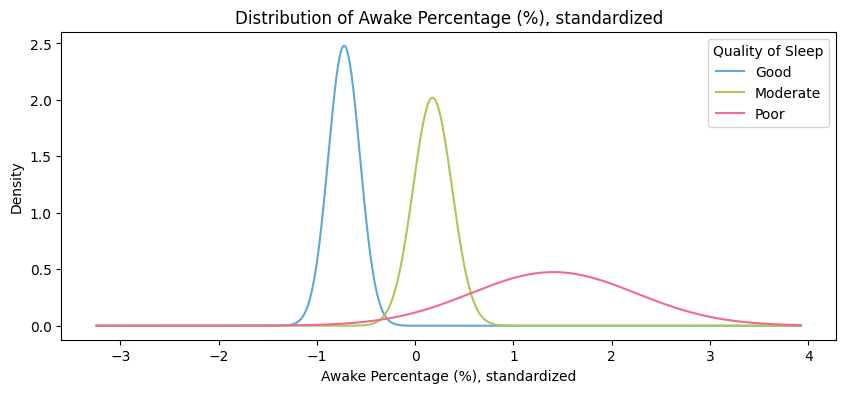

In [33]:
# After your main plotting code, create a new figure for just one plot
plt.figure(figsize=(10, 4))

# Recreate just the 4th plot (index 3)
i = 2
column = feature_cols[i]
means = model.means_[:, i]
covariances = model.covars_[:, i, i]
x = np.linspace(means.min() - 3 * covariances.max(), means.max() + 3 * covariances.max(), 1000)

colors = ["#5fa8d3", "#a7c957", "#f26a8d"]
labels = ['Good', 'Moderate', 'Poor']

for j in range(3):
    y = norm.pdf(x, means[j], covariances[j])
    plt.plot(x, y, c=colors[j], label=labels[j])

plt.xlabel(f'{column.title()}, standardized')
plt.ylabel('Density')
plt.title(f'Distribution of {column.title()}, standardized')
plt.legend(title='Quality of Sleep')
plt.savefig('feature-visualization.png', bbox_inches='tight', transparent=True)
plt.show()